In [176]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from statsmodels.stats.multitest import multipletests
from collections import OrderedDict

# Load results

In [177]:
def read_results(workdir, workdir_2=''):
    df = {}
    
    DEqMS = pd.read_csv(workdir+"/Central_res_irs_on_median.tsv", sep="\t", index_col=0)
    #DEqMS = DEqMS.applymap(lambda x: float(x.replace(",",".")))
    df["pv_DEqMS"] = DEqMS["sca.adj.pval"]
    df["lfc_DEqMS"] = DEqMS["logFC"]

    # Fisher
    ma_cm = pd.read_csv(workdir+"/MA_CM.tsv", sep="\t")
    ma_cm.index = ma_cm["Symbol"].values
    df["lfc_Fisher"] = ma_cm["metafc"]
    _, adj_pval,_,_ = multipletests(ma_cm["metap"].values, alpha=0.05, method='fdr_bh',
                                           is_sorted=False, returnsorted=False)
    df["pv_Fisher"] = pd.Series(adj_pval,index=ma_cm["metap"].index)

    # REM
    ma_rem = pd.read_csv(workdir+"/MA_REM.tsv", sep="\t")
    ma_rem.index = ma_rem["Symbol"].values
    df["lfc_REM"] = ma_rem["randomSummary"]
    _, adj_pval, _, _ = multipletests(ma_rem["randomP"].values, alpha=0.05, method='fdr_bh',
                                           is_sorted=False, returnsorted=False)
    df["pv_REM"] = pd.Series(adj_pval,index=ma_rem["randomP"].index)

    # fedprot
    # fedprot = pd.read_csv(workdir+"/results.FedProt.tsv", sep="\t", index_col=0)
    # df["pv_FedProt"] = fedprot["adj.P.Val"]
    # df["lfc_FedProt"] = fedprot["logFC"]

    ### Stoufer 
    stoufer  = pd.read_csv(workdir+"/MA_Stouffer.tsv", sep="\t", index_col=0)
    df["pv_Stouffer"] = stoufer["FDR"]
    df["lfc_Stouffer"] = df["lfc_Fisher"]  # take logFC from MetaVolcanoR
    ### RankProd
    rankprod  = pd.read_csv(workdir+"/MA_RankProd.tsv", sep="\t", index_col=0)
    rankprod["FDR"] = rankprod.loc[:,["down_reg.FDR","up_reg.FDR"]].min(axis=1)
    df["pv_RankProd"] = rankprod["FDR"]
    df["lfc_RankProd"] = rankprod["avgL2FC"] 
    
    df = pd.DataFrame.from_dict(df)
    df = df.dropna(axis=0)
    return df

In [178]:
root_dir = "/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/"

dfs = {}

workdir = root_dir + "pep_pg"
df = read_results(workdir)
dfs["pep_PG"] = df

workdir = root_dir + "gene"
df = read_results(workdir)
dfs["Genes"] = df

In [179]:
color_dict = OrderedDict()

color_dict["Methods"] = OrderedDict({"Fisher":"#E69F00",
                                     "Stouffer":"#D44400",
                                     "REM":"#009E73",
                                     "RankProd":"#2E5EAA"
})

# plot

In [180]:
from matplotlib.table import table

def plt_results(dfs, methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
                colors=["D44500","2E5EAA","FFFB0A","47A025","010B13"], 
                what="pv_", suptitle="$-log_{10}(adj.p-values)$", text="",dotsize=1,
                datasets=["Balanced", "Imbalanced"]):
    
    fig, axes = plt.subplots(1, 2, figsize=(10,4.5), sharey=False)
    i=0
    se = 0
    results = {}
    max_xlim = 0
    min_xlim = 0

    for k in datasets:
        df = dfs[k].filter([f'{what}DEqMS']+[what+i for i in methods])
        axes[i].set_title(k,fontsize=16)
        rmse = {}
        
        for j in range(len(methods)):
            method = methods[j]
            col = color_dict["Methods"][methods[j]]
            x = df[what+"DEqMS"].values
            y = df[what+method].values
            rmse[method] = np.sqrt(np.sum((x-y)**2)/len(x))
            axes[i].scatter(x = np.abs(x), y= np.abs(y),s=dotsize, color=col, alpha=0.5)
        
        axes[i].set_xlabel('-log10 adj.p-values (pyr/glu), DEqMS',fontsize=12)
        axes[i].set_ylabel('-log10 adj.p-values (pyr/glu), other methods',fontsize=12)
        axes[i].plot([np.min(np.abs(df.values)), np.max(np.abs(df.values))+5], 
                     [np.min(np.abs(df.values)), np.max(np.abs(df.values))+5],
                   color = "red",ls="--",lw=0.5)
     
        corrs = df[[what+"DEqMS"]+[what+m for m in methods]].corr().loc[[what+"DEqMS"],]
        corrs.rename(lambda x: x.replace(what,""), axis="columns",inplace = True)
        corrs = corrs.T.to_dict()[what+'DEqMS']
        rank_corrs = df[[what+"DEqMS"]+[what+m for m in methods]].corr(method="spearman").loc[[what+"DEqMS"],]
        rank_corrs.rename(lambda x: x.replace(what,""), axis="columns",inplace = True)
        rank_corrs = rank_corrs.T.to_dict()[what+'DEqMS']

        # Prepare data for table
        data = {}
        for j, method in enumerate(methods):
            if method == "FedProt":
                if rmse[method] < 1:
                    data[method] = [f"{round(corrs[method],3)}", f"{round(rank_corrs[method],3)}", f"{rmse[method]:.0e}"]
                else:
                    data[method] = [f"{round(corrs[method],3)}", f"{round(rank_corrs[method],3)}", f"{round(rmse[method], 2)}"]
            else:
                data[method] = [f"{round(corrs[method],3)}", f"{round(rank_corrs[method],3)}", f"{round(rmse[method],2)}"]

        # Create table for each axes
        colLabels = ["r", "ρ", "RMSE"]
        the_table = table(axes[i], cellText=list(data.values()),
                        colLabels=colLabels,
                        rowLabels=list(data.keys()),
                        cellLoc = 'center', rowLoc = 'right',
                        bbox=[0.5, 0.66, 0.5, 0.34],  
                        cellColours=[['white'] * len(colLabels) for col in color_dict["Methods"]]
                        )

        # Set font size for the entire table
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)  # Change this value as required

        for j, label in enumerate(data.keys()):
            cell = the_table.get_celld()[(j + 1, -1)]  # get the row label cell
            cell.set_facecolor(color_dict["Methods"][label])  # set the row label background color
            if label == "FedProt" or label == "RankProd":
                cell.get_text().set_color('white')  # set the row label text color 
            else:
                cell.get_text().set_color('black')
        i += 1
        results[(k,"r")] = corrs
        results[(k,"ρ")] = rank_corrs
        results[(k,"RMSE")] = pd.Series(rmse)

        max_xlim_method = np.max(np.abs(df[what+"DEqMS"].values))
        if what == "pv_":
            max_xlim_method = max_xlim_method + max_xlim_method*0.2
        else:
            max_xlim_method = max_xlim_method + max_xlim_method*0.05
        if max_xlim < max_xlim_method:
            max_xlim = max_xlim_method

        min_xlin_method = np.min(np.abs(df[what+"DEqMS"].values))
        min_xlin_method = min_xlin_method - max_xlim_method*0.01
        if min_xlim > min_xlin_method:
            min_xlim = min_xlin_method

    axes[0].set_xlim([min_xlim, max_xlim])
    axes[1].set_xlim([min_xlim, max_xlim])
    
    results = pd.DataFrame.from_dict(results)
    
    if text:
        tmp = axes[0].text(-0.2*np.max(df.values), np.max(df.values), text, fontsize=24)
        
    plt.tight_layout()
    return results.loc[methods,]

pep_PG                         Genes                    
                 r         ρ      RMSE         r         ρ      RMSE
Fisher    0.961203  0.886787  0.613694  0.963787  0.911204  0.620983
Stouffer  0.963113  0.840769  0.681248  0.962778  0.880554  0.682284
REM       0.870244  0.943009  1.233121  0.888735  0.951028  1.196329
RankProd  0.759983  0.868080  1.629693  0.732240  0.796204  1.822805

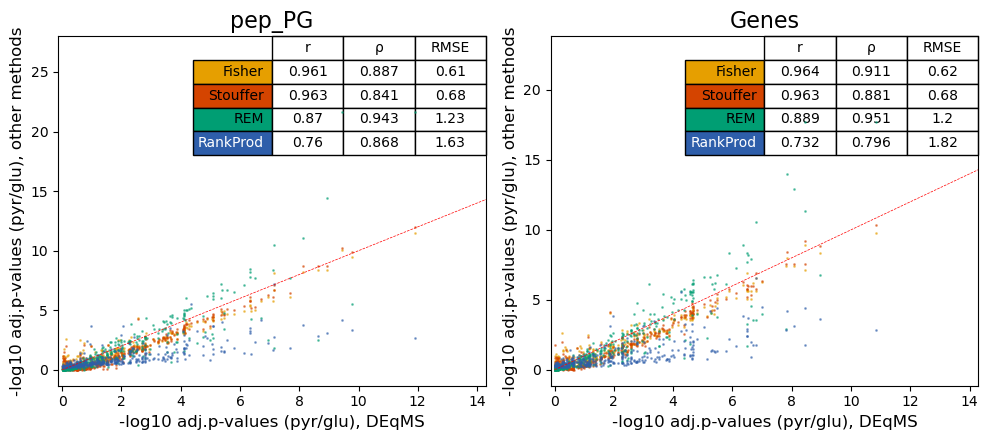

In [181]:
# log transform p-values in dfs, but first replace 0 with tiny value
log_dfs = {}
for k in dfs:
    df = dfs[k]
    df = df.replace(0,1e-300)
    df["pv_DEqMS"] = -np.log10(df["pv_DEqMS"])
    for m in ["Fisher","Stouffer","REM","RankProd"]:
        df["pv_"+m] = -np.log10(df["pv_"+m])
    log_dfs[k] = df



corrs = plt_results(log_dfs, text = "", colors = color_dict,
                    datasets=["pep_PG", "Genes"], methods=["Fisher","Stouffer","REM","RankProd"])
# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)
corrs

# plot 2

In [182]:
from matplotlib.colors import LinearSegmentedColormap

In [224]:
def calc_stats_TOP(
    df,
    stats=["TP","TN","FP","FN","Precision","Recall","F1", "Jaccard"],
    methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
    top_genes=-1):

    results={}
    all_genes = set(df.index.values)

    if top_genes<=0:
        top_genes = df.shape[0]
    de = df.sort_values(by="pv_DEqMS",ascending = False)
    de = de.head(top_genes)

    T = set(de.index.values)
    F = all_genes.difference(T)
    if len(set(stats).intersection(set(["TP", "TN", "FP", "FN", "Precision", "Recall", "F1", "Jaccard"]))) > 0:
        for m in methods:
            de2 = df.sort_values(by="pv_" + m, ascending=False)
            de2 = de2.head(top_genes)
            P = set(de2.index.values)
            N = all_genes.difference(P)

            TP = len(T.intersection(P))
            FP = len(F.intersection(P))
            TN = len(F.intersection(N))
            FN = len(T.intersection(N))

            # Calculate Precision, Recall, and F1
            Prec = TP / (TP + FP) if (TP + FP) > 0 else 0
            Rec = TP / (TP + FN) if (TP + FN) > 0 else 0
            F1 = 2 * (Prec * Rec) / (Prec + Rec) if Prec and Rec else 0

            # Calculate Jaccard Similarity
            Jaccard = len(T.intersection(P)) / len(T.union(P)) if len(T.union(P)) > 0 else 0
            results[m] = {"TP": TP, "FP": FP, "TN": TN, "FN": FN, "Precision": Prec, "Recall": Rec, "F1": F1, "Jaccard": Jaccard}
    
    if len(results.keys())>0:
        results = pd.DataFrame.from_dict(results).T
    if type(results)==dict:
        results = pd.DataFrame.from_dict(results)
    return results.loc[:,stats]

In [225]:
def plot_stats_for_topN(dfs,
                        datasets=["Balance", "Mild Imbalance", "Strong Imbalance"],
                        metrics=["F1", "Jaccard"],
                        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
                        colors=["red", "blue", "cyan", "lightgreen", "grey"],
                        min_n_genes=10, max_n_genes=1000, step=10,
                        text="",
                        log=False, figfile="", suptitle="", sharey=False):

    """Calculated and plots statisctics for top N genes ordered by p-value.
   Top genes are chosen based on a sliding threshold, starting from 'min_n_genes' and moving to 'max_n_genes' with 'step'."""
    cmap = LinearSegmentedColormap.from_list("from_dict", list(color_dict["Methods"].values()))
    fig, all_axes = plt.subplots(len(metrics), len(datasets), figsize=(13,4*len(metrics)), sharey=sharey)
    all_stats = {}
    min_ylim = {}
    max_ylim = {}

    for k in range(len(metrics)):
        metric = metrics[k]
        all_stats[metric] = {}
        if len(metrics) == 1:
            axes = all_axes
        else:
            axes = all_axes[k]
        for i in range(len(datasets)):
            ds = datasets[i]
            df = dfs[ds]
            df = df.sort_values(by="pv_DEqMS", ascending=False)
            stats = {}
            top_n_genes = np.arange(min_n_genes, max_n_genes, step)
            for j in range(len(top_n_genes)):  #
                confusion_matrix = calc_stats_TOP(df, 
                                                  stats=[metric],
                                                  methods=methods, 
                                                  top_genes=top_n_genes[j])
                stats[top_n_genes[j]] = confusion_matrix[metric]
            stats = pd.DataFrame.from_dict(stats)
            stats.T.plot(ax=axes[i], cmap=cmap)
            min_ylim[metric] = min(min_ylim.get(metric, float('inf')), stats.values.min())
            max_ylim[metric] = max(max_ylim.get(metric, float('-inf')), stats.values.max())

            if log:
                axes[i].set_yscale('log')
            # print(stats)
            if k == len(metrics) - 1:
                tmp = axes[i].set_xlabel("number of top-ranked proteins", fontsize=14)
            if i == 0:
                if log:
                    tmp = axes[i].set_ylabel("$log_{10}($" + metric + "$)$", fontsize=24)
                else:
                    if metric == 'RMSE':
                        tmp = axes[i].set_ylabel(f'{metric}, -log10(p-values)', fontsize=18)
                    else:
                        tmp = axes[i].set_ylabel(metric, fontsize=18)
                if text:
                    tmp = axes[0].text(-0.15 * max_n_genes, np.max(stats.values) * 1.0, text, fontsize=24)
            if i > 0 or k != len(metrics) - 1:
                axes[i].get_legend().remove()
            if k == 0:
                tmp = axes[i].set_title(ds, fontsize=20)
            all_stats[metric][ds] = stats

    for k in range(len(metrics)):
        metric = metrics[k]
        for i in range(len(datasets)):
            if log:
                all_axes[k][i].set_yscale('log')
            if len(metrics) > 1:
                all_axes[k][i].set_ylim(min_ylim[metric] - 0.1 * (max_ylim[metric] - min_ylim[metric]),
                                        max_ylim[metric] + 0.1 * (max_ylim[metric] - min_ylim[metric]))
                # set y ticks from 0 to 1 with 0.1 step
                

    for ax_row in np.atleast_1d(all_axes):
        for ax in np.atleast_1d(ax_row):  # Make sure it works for both 1D and 2D arrays of axes
            ax.plot([min_n_genes, max_n_genes], [1, 1], linestyle='--', color='grey', linewidth=1)
            ax.set_yticks(np.arange(0, 1.1, 0.1))

    if suptitle:
        fig.suptitle(suptitle, fontsize=24)
    if figfile:
        fig.savefig(figfile)
    return all_stats


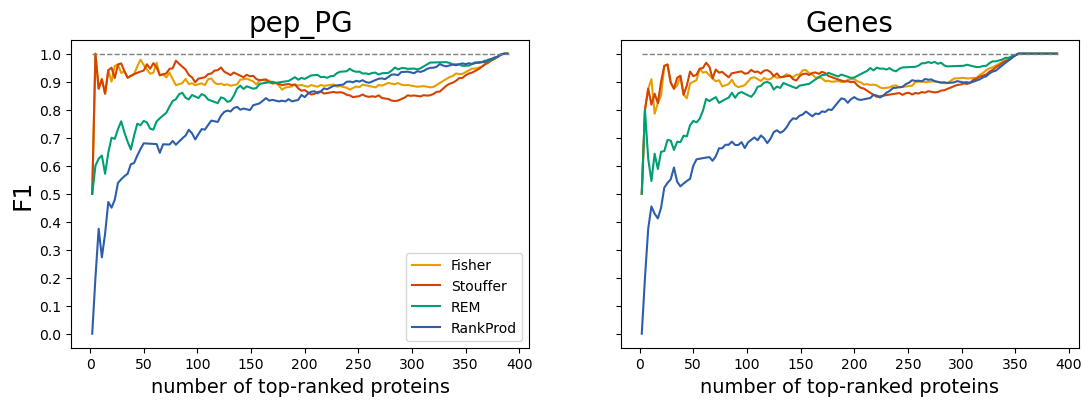

In [230]:
min_n_genes = 2
step = 3
max_n_genes = 390

data = plot_stats_for_topN(log_dfs,
                           datasets = ["pep_PG", "Genes"],
                           methods=["Fisher","Stouffer","REM","RankProd"],
                           metrics=["F1"],
                           min_n_genes=min_n_genes,
                           max_n_genes = max_n_genes,
                           step=step,
                           colors=color_dict,
                           sharey=True)

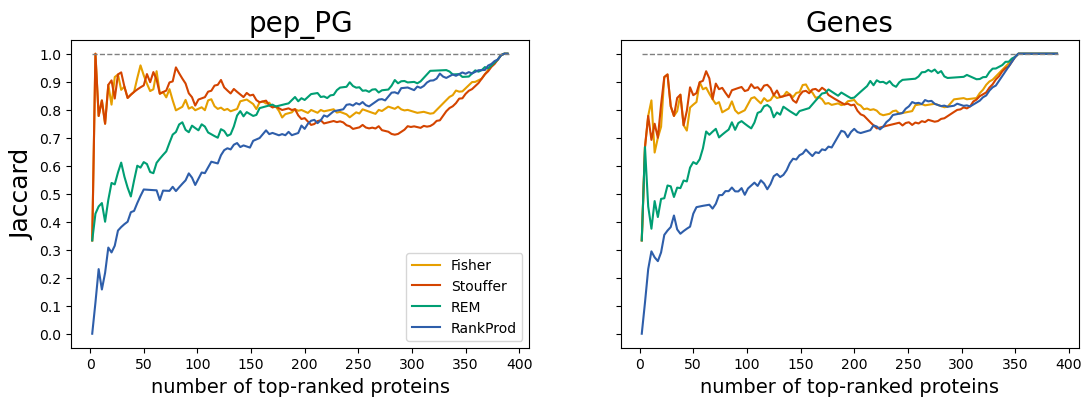

In [229]:
min_n_genes = 2
step = 3
max_n_genes = 390

data = plot_stats_for_topN(log_dfs,
                           datasets = ["pep_PG", "Genes"],
                           methods=["Fisher","Stouffer","REM","RankProd"],
                           metrics=["Jaccard"],
                           min_n_genes=min_n_genes,
                           max_n_genes = max_n_genes,
                           step=step,
                           colors=color_dict,
                           sharey=True)

# Table 1

In [189]:
def calc_stats_log(df,lfc_thr=1, adj_pval_thr = -np.log10(0.05),
               stats=["TP","TN","FP","FN","Precision","Recall","F1","r","ρ","RMSE"],
               methods=["FedProt","Fisher","Stouffer","REM","RankProd"],top_genes=-1):
    results={}
    all_genes = set(df.index.values)

    if top_genes<=0:
        top_genes = df.shape[0]
    #de = df.sort_values(by="pv_DEqMS",ascending = False)
    de = df.loc[(df["pv_DEqMS"]>adj_pval_thr) & (np.abs(df["lfc_DEqMS"])>=lfc_thr),:]
    de = de.head(top_genes)
    
    # truth: DE and not DE genes predicted by limma
    T = set(de.index.values)
    F = all_genes.difference(T)
    #prnt("T:",len(T), "F:",len(F))
    if len(set(stats).intersection(set(["TP","TN","FP","FN","Precision","Recall","F1"])))>0:
        for m in methods:
            # prediction
            de2 = df.loc[:,["pv_"+m,"lfc_"+m]].sort_values(by="pv_"+m,ascending = False)
            de2 = de2.loc[de2["pv_"+m]>adj_pval_thr,:]
            de2 = de2.loc[np.abs(de2["lfc_"+m])>=lfc_thr,:].head(top_genes)
            P = set(de2.index.values)
            N = all_genes.difference(P)
            
            TP=len(T.intersection(P))
            FP = len(F.intersection(P))
            TN = len(F.intersection(N))
            FN = len(T.intersection(N))
            if (TP+FP)>0:
                Prec = TP*1.0/(TP+FP)
            else:
                Prec =0
            if (TP+FN) >0:
                Rec = TP*1.0/(TP+FN)
            else:
                Rec = 0
            if Prec and Rec:
                F1 = 2* (Prec*Rec)/(Prec+Rec)
            else:
                F1=0

            results[m] = {"TP":TP,"FP":FP,
                            "TN":TN,"FN":FN,
                             "Precision":Prec,"Recall":Rec, "F1":F1}

    # correlation of all p-values
    if "RMSE" in stats:
        for m in methods:
            # RMSE for -log10 p-values
            df = df.sort_values(by="pv_DEqMS",ascending = False).head(top_genes)
            x = df["pv_DEqMS"].values
            y = df["pv_"+m].values
            rmse = np.sqrt(np.sum((x-y)**2)/len(x))
            if m in results.keys():
                results[m]["RMSE"] = rmse
            else:
                results[m] = {"RMSE":rmse}
    # turn results to df if it is not empty
    if len(results.keys())>0:
        results = pd.DataFrame.from_dict(results).T
    if "r" in stats:
        df = df.sort_values(by="pv_DEqMS",ascending = False).head(top_genes)
        corrs = df[["pv_"+"DEqMS"]+["pv_"+m for m in methods]].corr().loc[["pv_"+"DEqMS"],]
        corrs.rename(lambda x: x.replace("pv_",""), axis="columns",inplace = True)
        corrs = corrs.loc[:,methods]
        corrs = corrs.T['pv_DEqMS']
        results["r"] = corrs
        
    if "ρ" in stats: 
        df = df.sort_values(by="pv_DEqMS",ascending = False).head(top_genes)
        rank_corrs = df[["pv_"+"DEqMS"]+["pv_"+m for m in methods]].corr(method="spearman").loc[["pv_"+"DEqMS"],]
        rank_corrs.rename(lambda x: x.replace("pv_",""), axis="columns",inplace = True)
        rank_corrs = rank_corrs.loc[:,methods]
        rank_corrs = rank_corrs.T['pv_DEqMS']
        results["ρ"] = rank_corrs
    
    # turn results to df if it is still a dict
    if type(results)==dict:
        results = pd.DataFrame.from_dict(results)
    return results.loc[:,stats]

In [190]:
stats = {}
stats2  = {}

for m in ["FP","FN","F1","Precision","Recall"]:
    for ds in ["pep_PG", "Genes"]:  # ,"Mild Imbalance","Strong Imbalance"
        df = log_dfs[ds].sort_values(by="pv_DEqMS", ascending = True)
        results = calc_stats_log(df, lfc_thr=0.25, adj_pval_thr = -np.log10(0.01),
                             methods=["Fisher","Stouffer","REM","RankProd"])
        stats[(m,ds)] = results[m]
    #print(confusion_matrix)

results_npf = pd.DataFrame.from_dict(stats)
results_npf

FP           FN              F1           Precision            \
         pep_PG Genes pep_PG Genes    pep_PG     Genes    pep_PG     Genes   
Fisher      1.0   0.0   14.0  14.0  0.917127  0.917647  0.988095  1.000000   
Stouffer    1.0   0.0   24.0  15.0  0.853801  0.911243  0.986486  1.000000   
REM         7.0   4.0   19.0  14.0  0.857143  0.896552  0.917647  0.951220   
RankProd    5.0   2.0   61.0  56.0  0.521739  0.553846  0.878049  0.947368   

            Recall            
            pep_PG     Genes  
Fisher    0.855670  0.847826  
Stouffer  0.752577  0.836957  
REM       0.804124  0.847826  
RankProd  0.371134  0.391304